In [23]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
from tqdm import tqdm
%matplotlib inline

# Read in Citibike stations.

We will use this shapefile to lookup neighborhood codes by station id.

In [2]:
root = ".."
inputfile = join(root, "data", "citibike_stations", "spatial_join.shp")
stations = gpd.read_file(inputfile)

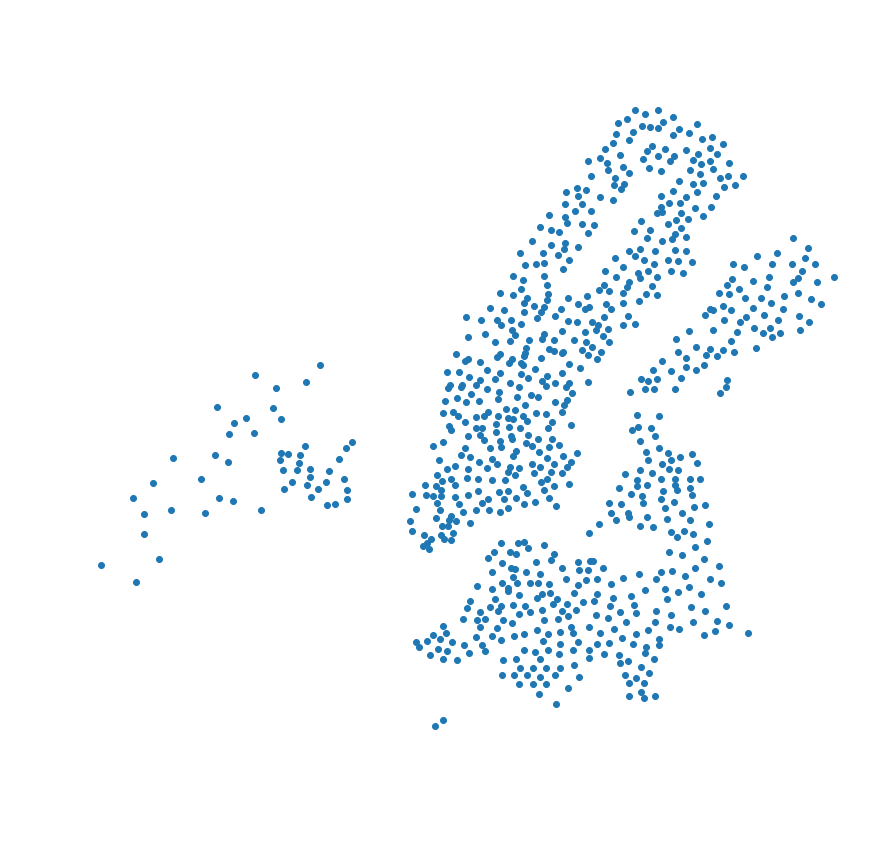

Citibike Stations


In [3]:
f, ax = plt.subplots(1, figsize=(15,15))
stations.plot(ax=ax, )
ax.set_axis_off()
plt.axis('equal')
plt.show()
print("Citibike Stations")

In [4]:
stations.head()

,id,name,test,docks,index_righ,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,72,W 52 St & 11 Ave,0,39,70,1,Manhattan,061,MN15,Clinton,35037.171670,1.838139e+07,POINT (-73.99392888 40.76727216)
1,79,Franklin St & W Broadway,0,33,101,1,Manhattan,061,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26854.636018,2.503262e+07,POINT (-74.00666661 40.71911552)
2,82,St James Pl & Pearl St,0,27,114,1,Manhattan,061,MN27,Chinatown,20786.256014,1.450187e+07,POINT (-74.00016545 40.71117416)
3,83,Atlantic Ave & Fort Greene Pl,0,62,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97632328 40.68382604)
4,119,Park Ave & St Edwards St,0,19,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97803415 40.69608941)


# Read in Neighborhoods

In [5]:
inputfile = join(root, "data", "neighborhood_tabulation_areas", "nyc_and_jc_neighborhoods",
                 "nyc_and_jc_neighborhoods.shp")
neighborhoods = gpd.read_file(inputfile)

In [6]:
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK88,Borough Park,39247.228028,5.400502e+07,POLYGON ((-73.97604935657381 40.63127590564677...
1,4,Queens,081,QN52,East Flushing,25843.364936,2.945438e+07,POLYGON ((-73.79493246233996 40.75779803007455...
2,4,Queens,081,QN48,Auburndale,32446.878673,3.416422e+07,POLYGON ((-73.77573836927098 40.74332564716399...
3,4,Queens,081,QN51,Murray Hill,33266.904811,5.248828e+07,POLYGON ((-73.80379022888246 40.77561011179249...
4,4,Queens,081,QN27,East Elmhurst,19816.712323,1.972685e+07,"POLYGON ((-73.86109724335759 40.7636644770869,..."


# Create master arrivals dataframe

In [10]:
arrivals = []

for i in tqdm(os.listdir(citibike_trips_path)):
    
    df = pd.read_csv(join(citibike_trips_path, i))
    df = pd.merge(df, stations[['id', 'BoroName','NTACode', 'NTAName']],
                     how='left', left_on='end_station_id', right_on='id')
    arrivals_df = df[['stoptime', 'end_station_id', 'end_station_latitude',
                  'end_station_longitude', 'BoroName','NTACode', 'NTAName']]
    arrivals.append(arrivals_df)


  7%|▋         | 4/54 [00:05<01:12,  1.44s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py36/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 54/54 [03:10<00:00,  3.54s/it]


In [11]:
%%time
arrivals = pd.concat(arrivals)

CPU times: user 3.07 s, sys: 4.37 s, total: 7.44 s
Wall time: 7.77 s


In [12]:
arrivals_with_nans = arrivals[arrivals['NTACode'].astype(str) == "nan"].copy()

# Add spatial reference to dataframe
geometry = [Point(xy) for xy in zip(arrivals_with_nans.end_station_longitude,
                                    arrivals_with_nans.end_station_latitude)]
crs = {'init': 'epsg:4326'}
arrivals_with_nans = gpd.GeoDataFrame(arrivals_with_nans, crs=crs, geometry=geometry)

In [13]:
arrivals_with_nans = gpd.sjoin(arrivals_with_nans, neighborhoods, how="left", op='within')

In [14]:
del arrivals_with_nans['BoroName_left']
del arrivals_with_nans['NTACode_left']
del arrivals_with_nans['NTAName_left']
del arrivals_with_nans['index_right']
del arrivals_with_nans['Shape_Leng']
del arrivals_with_nans['Shape_Area']
del arrivals_with_nans['geometry']
del arrivals_with_nans['BoroCode']
del arrivals_with_nans['CountyFIPS']

In [15]:
arrivals_with_nans.rename(columns={'BoroName_right': 'BoroName', 'NTACode_right': 'NTACode', 'NTAName_right': 'NTAName'},
                            inplace=True)

In [16]:
# drop nans
arrivals = arrivals.dropna(subset=['NTACode'])

In [17]:
# add the spatially joined nan's back in
arrivals = pd.concat([arrivals, arrivals_with_nans])

In [18]:
arrivals.head()

,stoptime,end_station_id,end_station_latitude,end_station_longitude,BoroName,NTACode,NTAName
0,2016-01-01 00:08:54,3209,40.724176,-74.050656,Jersey City,JC,Jersey City
1,2016-01-01 00:21:42,3213,40.718489,-74.047727,Jersey City,JC,Jersey City
2,2016-01-01 00:21:47,3213,40.718489,-74.047727,Jersey City,JC,Jersey City
3,2016-01-01 00:27:21,3203,40.727596,-74.044247,Jersey City,JC,Jersey City
4,2016-01-01 01:18:24,3210,40.742677,-74.051789,Jersey City,JC,Jersey City


In [42]:
arrivals.shape

(35116629, 7)

In [43]:
%%time
arrivals['stoptime'] = pd.to_datetime(arrivals['stoptime'])

CPU times: user 25min 38s, sys: 14.7 s, total: 25min 52s
Wall time: 26min 6s


In [44]:
%%time
output_dir = join(root, "data", "citibike_arrivals")
output_filename = "citibike_arrivals.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
arrivals.to_csv(join(output_dir, output_filename))

CPU times: user 4min, sys: 10.5 s, total: 4min 10s
Wall time: 4min 19s


# Total 2016 - 2018 Arrivals by Neighborood

In [45]:
arrivals_by_neighborhood = arrivals.groupby(by='NTAName').count()
arrivals_by_neighborhood['count'] = arrivals_by_neighborhood['NTAName']
arrivals_by_neighborhood = arrivals_by_neighborhood[['count']]
arrivals_by_neighborhood.sort_values('count', ascending=False)

,count
NTAName,
Hudson Yards-Chelsea-Flatiron-Union Square,4393115
Midtown-Midtown South,3266017
West Village,3189045
SoHo-TriBeCa-Civic Center-Little Italy,2530706
Murray Hill-Kips Bay,1939019
Battery Park City-Lower Manhattan,1834176
East Village,1561732
Clinton,1302132
Chinatown,1174690


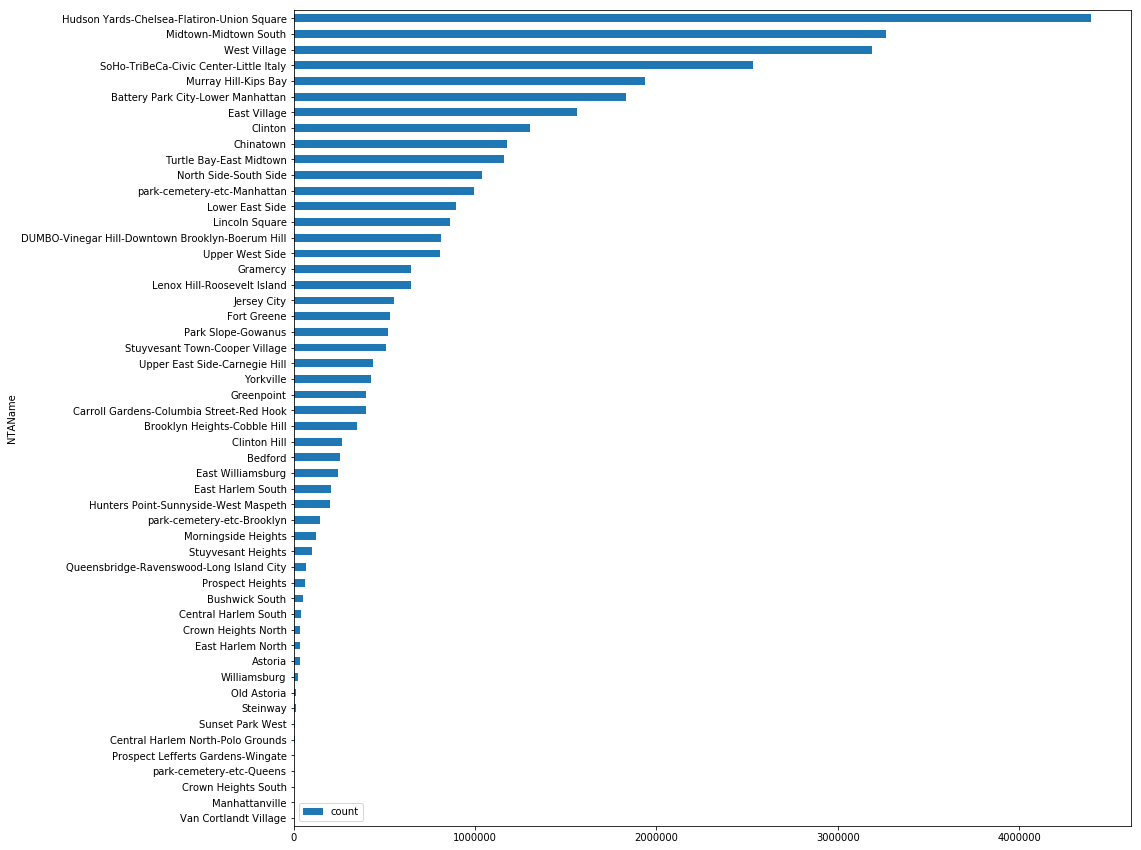

In [46]:
f, ax = plt.subplots(1, figsize=(15,15))
arrivals_by_neighborhood.sort_values('count').plot(ax=ax, kind='barh')
#ax.set_axis_off()
plt.show()

/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


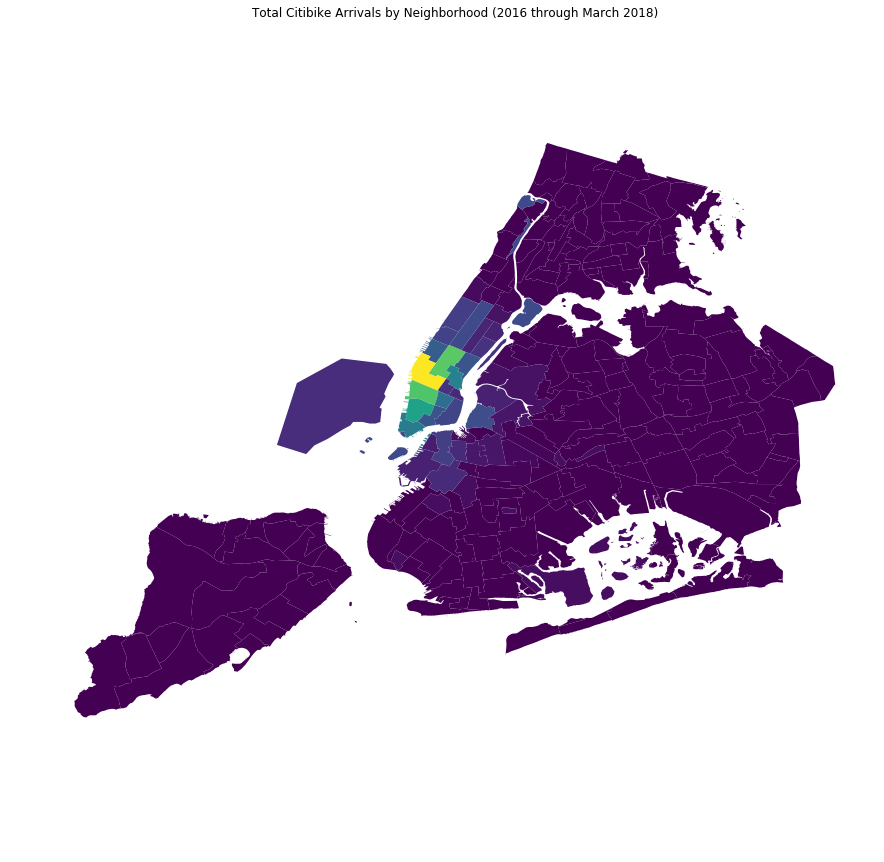

In [59]:
neighborhoods.index = neighborhoods['NTAName']

f, ax = plt.subplots(1, figsize=(15,15))
neighborhoods.join(arrivals_by_neighborhood, how='left').plot(column='count', ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.title("Total Citibike Arrivals by Neighborhood (2016 through March 2018)")
plt.show()

# 2016 - 2018 Total Citibike Monthly Arrivals over Time

In [51]:
arrivals_monthly = arrivals.resample('M', on='stoptime').count()
arrivals_monthly['count'] = arrivals_monthly['NTAName']
arrivals_monthly = arrivals_monthly[['count']]

In [52]:
arrivals_monthly.head()

,count
stoptime,
2016-01-31,516878
2016-02-29,569124
2016-03-31,933298
2016-04-30,1029401
2016-05-31,1231830


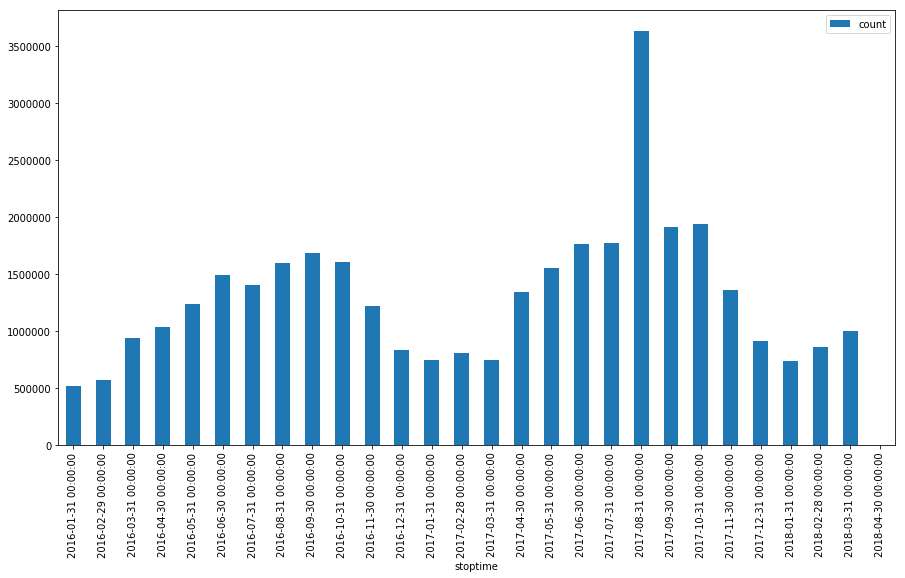

In [58]:
f, ax = plt.subplots(1, figsize=(15,8))
arrivals_monthly.plot(ax=ax, kind='bar')
#ax.set_axis_off()
plt.show()

# 2016 - 2018 Monthly Arrivals by Neighborhood

In [68]:
arrivals['year'] = arrivals['stoptime'].dt.year
arrivals['year'] = arrivals['year'].astype(str)

In [70]:
arrivals['month'] = arrivals['stoptime'].dt.month
arrivals['month'] = arrivals['month'].astype(str)
arrivals['month'] = arrivals['month'].str.zfill(2)

In [72]:
arrivals['yearMonth'] = arrivals['year'] + arrivals['month']

In [108]:
arrivals.head()

,stoptime,end_station_id,end_station_latitude,end_station_longitude,BoroName,NTACode,NTAName,year,month,yearMonth,yearMonthId
0,2016-01-01 00:08:54,3209,40.724176,-74.050656,Jersey City,JC,Jersey City,2016,01,201601,0.0
1,2016-01-01 00:21:42,3213,40.718489,-74.047727,Jersey City,JC,Jersey City,2016,01,201601,0.0
2,2016-01-01 00:21:47,3213,40.718489,-74.047727,Jersey City,JC,Jersey City,2016,01,201601,0.0
3,2016-01-01 00:27:21,3203,40.727596,-74.044247,Jersey City,JC,Jersey City,2016,01,201601,0.0
4,2016-01-01 01:18:24,3210,40.742677,-74.051789,Jersey City,JC,Jersey City,2016,01,201601,0.0


In [125]:
arrivals = arrivals.dropna()

In [126]:
arrivals.shape

(35116313, 11)

In [136]:
%%time
arrivals_monthly_by_neighborhood = arrivals.groupby(by=['NTACode', 'yearMonth']).count()
arrivals_monthly_by_neighborhood['citibike_arrivals'] = arrivals_monthly_by_neighborhood['stoptime']
arrivals_monthly_by_neighborhood = arrivals_monthly_by_neighborhood[['citibike_arrivals']]
arrivals_monthly_by_neighborhood = pd.DataFrame.from_records(arrivals_monthly_by_neighborhood.to_records())

CPU times: user 11.3 s, sys: 12.8 s, total: 24.1 s
Wall time: 28.3 s


In [137]:
arrivals_monthly_by_neighborhood.head()

,NTACode,yearMonth,citibike_arrivals
0,BK09,201601,3892
1,BK09,201602,4498
2,BK09,201603,7443
3,BK09,201604,8779
4,BK09,201605,11049


In [138]:
%%time
output_dir = join(root, "data", "citibike_arrivals")
output_filename = "citibike_arrivals_monthly_by_neighborhood.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

arrivals_monthly_by_neighborhood.to_csv(join(output_dir, output_filename))

CPU times: user 5.49 ms, sys: 7.2 ms, total: 12.7 ms
Wall time: 17.5 ms


In [139]:
%%time
output_dir = join(root, "data", "_model_inputs")
output_filename = "citibike_arrivals_monthly_by_neighborhood.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

arrivals_monthly_by_neighborhood.to_csv(join(output_dir, output_filename))

CPU times: user 3.99 ms, sys: 2.32 ms, total: 6.31 ms
Wall time: 5.54 ms


# Below is only necessary if we decide to build LSTM for hourly forecasts

# Count hourly arrivals (with timelags) by Neighborhood

Note: This the below is only necessary if we decide to do an LSTM model on an hourly basis.

In [221]:
arrivals = arrivals.dropna(subset=['BoroName', 'NTACode', 'NTAName'])
unique_origin_neighborhoods_in_arrivals = list(np.unique(arrivals['NTACode'].values))

In [222]:
%%time
arrivals['stoptime'] = pd.to_datetime(arrivals['stoptime'])

CPU times: user 219 ms, sys: 258 ms, total: 477 ms
Wall time: 477 ms


In [223]:
arrivals_by_neighborhood_lagged = []

for n in tqdm(unique_origin_neighborhoods_in_arrivals):
    subset = arrivals[arrivals['NTACode'] == n].copy()
    subset_hourly = subset.resample('H', on='stoptime').count()[['stoptime']].reindex(hour_range).fillna(0)
    subset_hourly.columns = [n]
    for i in range(1, num_lagging_periods+1):
        column_name = '{}_t-{}'.format(n, i)
        subset_hourly[column_name] = subset_hourly[n].shift(i)
    arrivals_by_neighborhood_lagged.append(subset_hourly)

100%|██████████| 52/52 [01:23<00:00,  1.61s/it]


In [224]:
arrivals_by_neighborhood_lagged = pd.concat(arrivals_by_neighborhood_lagged, axis=1)
arrivals_by_neighborhood_lagged.dropna(inplace=True)

In [226]:
%%time
arrivals_by_neighborhood_lagged.to_csv(join("data", "citibike_arrivals", "citibike_arrivals_lags.csv"))